In [5]:
import os 
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
import h5py
import numpy as np 


from scipy.integrate import simps
from scipy.optimize import curve_fit
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.lines import Line2D
from scipy.interpolate import CubicSpline
from PIL import Image

sns.set_context("talk")

%matplotlib inline

In [2]:


# Fit the resolution data to a polynomial for extrapolation
def poly_func(x, a, b, c):
    return a * x**2 + b * x + c

# Create a function to get resolution for any energy
def get_resolution(e,popt):
    return np.maximum(poly_func(e, *popt), 1e-10)  # Ensure non-zero resolution


# Perform Gaussian broadening using convolution with energy-dependent widths
def gaussian_broadening(dos, energy, sigmas):
    broadened_dos = np.zeros_like(dos)
    for i in range(len(energy)):
        # Create a Gaussian kernel centered at each energy point with width sigmas[i]
        kernel = np.exp(-0.5 * ((energy - energy[i]) / sigmas[i])**2)
        kernel /= simps(kernel, energy)  # Normalize the kernel to preserve area
        broadened_dos += dos[i] * kernel  # Convolve DOS with Gaussian kernel
    return broadened_dos

def apply_gaussian_broadening(dos_data,metric='dos total (nm2/ps)',unit_cell_atoms=1):
    energy = dos_data['Energy Transfer (meV)'].values
    dos = dos_data[metric].values

    resolution_data = pd.read_csv('../data/experiment/resolution.csv')
    res_energy = resolution_data['Energy (meV)'].values
    resolution = resolution_data['Resolution'].values
    popt, _ = curve_fit(poly_func, res_energy, resolution)
    
    # Create an array of sigmas for Gaussian broadening based on the resolution function
    sigmas = get_resolution(energy,popt) / np.sqrt(8 * np.log(2))  # Convert FWHM to sigma


    broadened_dos = gaussian_broadening(dos, energy, sigmas)

    # Area normalize both original and broadened DOS
    original_area = simps(dos, energy)
    broadened_area = simps(broadened_dos, energy)

    dos_normalized = dos / original_area
    broadened_dos_normalized = broadened_dos / broadened_area
    return 3*unit_cell_atoms*broadened_dos_normalized

In [3]:
results_directory={"../results/gromacs/cluster/1nm_2x2x2/results/md_phonon_200/":{"System":r"$2 \times 2 \times 2$ Cluster","Radius (nm)":1}
                  ,"../results/gromacs/nanoparticle/1nm/results/md_phonon_200/":{"System":"Nanoparticle","Radius (nm)":1}
                  ,"../results/gromacs/cluster/2nm_2x2x2/results/md_phonon_200/":{"System":r"$2 \times 2 \times 2$ Cluster","Radius (nm)":2}
                  ,"../results/gromacs/nanoparticle/2nm/results/md_phonon_200/":{"System":"Nanoparticle","Radius (nm)":2}
                  
                  }
df_list=list()

min_energy=0.25
max_energy=150

for data_directory,value in results_directory.items():
    for filename in os.listdir(data_directory):
        if not "dos.h5" in filename:
            continue
        print(os.path.join(data_directory,filename))
        h5file=h5py.File(os.path.join(data_directory,filename))
        data_dict=dict()
        omega_shape=h5file["omega"][:].shape
        for k in h5file.keys():
            data_array=h5file[k][:]
            if data_array.shape != omega_shape or "_0" in k:
                continue
            units=h5file[k].attrs['units']
            data_dict["%s (%s)"%(k.replace("_"," "),units)]=data_array
        df_tmp=pd.DataFrame(data_dict).query("%f < `omega (rad/ps)` and `omega (rad/ps)` < %f"%(min_energy/0.6582,max_energy/0.6582))
        directory_split=data_directory.split("/")
        df_tmp["Weight"]=" ".join(filename.split("_")[:-1]).replace('b ','').capitalize()
        df_tmp["Method"]="GROMACS"
        df_tmp["Force Field"]="LJ"
        df_tmp["Energy Transfer (meV)"]=df_tmp["omega (rad/ps)"]*0.6582
        df_tmp["Normalized Count"]=apply_gaussian_broadening(df_tmp,unit_cell_atoms=137)
        for species,unit_cell_atoms in {"Fe":105-32,"O":32}.items():
            df_tmp[species]=apply_gaussian_broadening(df_tmp,"dos %s (nm2/ps)"%species,unit_cell_atoms)
            df_tmp["Max Normalized %s"%species]=df_tmp[species]/df_tmp[species].max()
        df_tmp["Max Normalized Count"]=df_tmp["Normalized Count"]/df_tmp["Normalized Count"].max()
        df_tmp["System"]=value["System"]
        df_tmp["Radius (nm)"]=value["Radius (nm)"]
        df_tmp["Software"]=directory_split[2]
        
        df_list.append(df_tmp)
        
df_dos_gromacs=pd.concat(df_list,ignore_index=True)
df_dos_gromacs

../results//gromacs/cluster/1nm_2x2x2/results/md_phonon_200/b_coherent_dos.h5
../results//gromacs/cluster/1nm_2x2x2/results/md_phonon_200/b_incoherent_dos.h5
../results/gromacs/nanoparticle/1nm/results/md_phonon_200/b_coherent_dos.h5
../results/gromacs/nanoparticle/1nm/results/md_phonon_200/b_incoherent_dos.h5
../results/gromacs/cluster/2nm_2x2x2/results/md_phonon_200/b_coherent_dos.h5
../results/gromacs/cluster/2nm_2x2x2/results/md_phonon_200/b_incoherent_dos.h5
../results/gromacs/nanoparticle/2nm/results/md_phonon_200/b_coherent_dos.h5
../results/gromacs/nanoparticle/2nm/results/md_phonon_200/b_incoherent_dos.h5


,dos Fe (nm2/ps),dos O (nm2/ps),dos total (nm2/ps),omega (rad/ps),omega window (au),time window (au),Weight,Method,Force Field,Energy Transfer (meV),Normalized Count,Fe,Max Normalized Fe,O,Max Normalized O,Max Normalized Count,System,Radius (nm),Software
0,1.477514e-06,1.417820e-06,1.450889e-06,0.439867,2.275494,9.975530e-01,Coherent,GROMACS,LJ,0.289520,0.086763,0.086087,0.011601,0.012672,0.007924,0.013291,$2 \times 2 \times 2$ Cluster,1,
1,1.596371e-06,1.531292e-06,1.567345e-06,0.502705,2.209094,9.968051e-01,Coherent,GROMACS,LJ,0.330881,0.036049,0.035774,0.004821,0.005264,0.003292,0.005522,$2 \times 2 \times 2$ Cluster,1,
2,1.733059e-06,1.661830e-06,1.701290e-06,0.565543,2.136179,9.959582e-01,Coherent,GROMACS,LJ,0.372241,0.042390,0.042074,0.005670,0.006189,0.003870,0.006493,$2 \times 2 \times 2$ Cluster,1,
3,1.888221e-06,1.810062e-06,1.853361e-06,0.628381,2.057531,9.950125e-01,Coherent,GROMACS,LJ,0.413601,0.046179,0.045841,0.006177,0.006741,0.004215,0.007074,$2 \times 2 \times 2$ Cluster,1,
4,2.062518e-06,1.976632e-06,2.024211e-06,0.691220,1.973969,9.939683e-01,Coherent,GROMACS,LJ,0.454961,0.050436,0.050072,0.006747,0.007361,0.004603,0.007726,$2 \times 2 \times 2$ Cluster,1,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28955,1.478329e-08,1.814564e-07,2.415547e-08,227.599737,0.000000,3.587767e-17,Incoherent,GROMACS,LJ,149.806147,0.001165,0.000391,0.000046,0.000865,0.000472,0.000083,Nanoparticle,2,gromacs
28956,1.474921e-08,1.809287e-07,2.409363e-08,227.662575,0.000000,-5.551670e-19,Incoherent,GROMACS,LJ,149.847507,0.001161,0.000389,0.000046,0.000862,0.000471,0.000083,Nanoparticle,2,gromacs
28957,1.471581e-08,1.804061e-07,2.403272e-08,227.725413,0.000000,2.006408e-17,Incoherent,GROMACS,LJ,149.888867,0.001157,0.000388,0.000046,0.000859,0.000469,0.000083,Nanoparticle,2,gromacs
28958,1.468309e-08,1.798888e-07,2.397276e-08,227.788251,0.000000,1.413941e-18,Incoherent,GROMACS,LJ,149.930227,0.001153,0.000387,0.000046,0.000856,0.000467,0.000083,Nanoparticle,2,gromacs


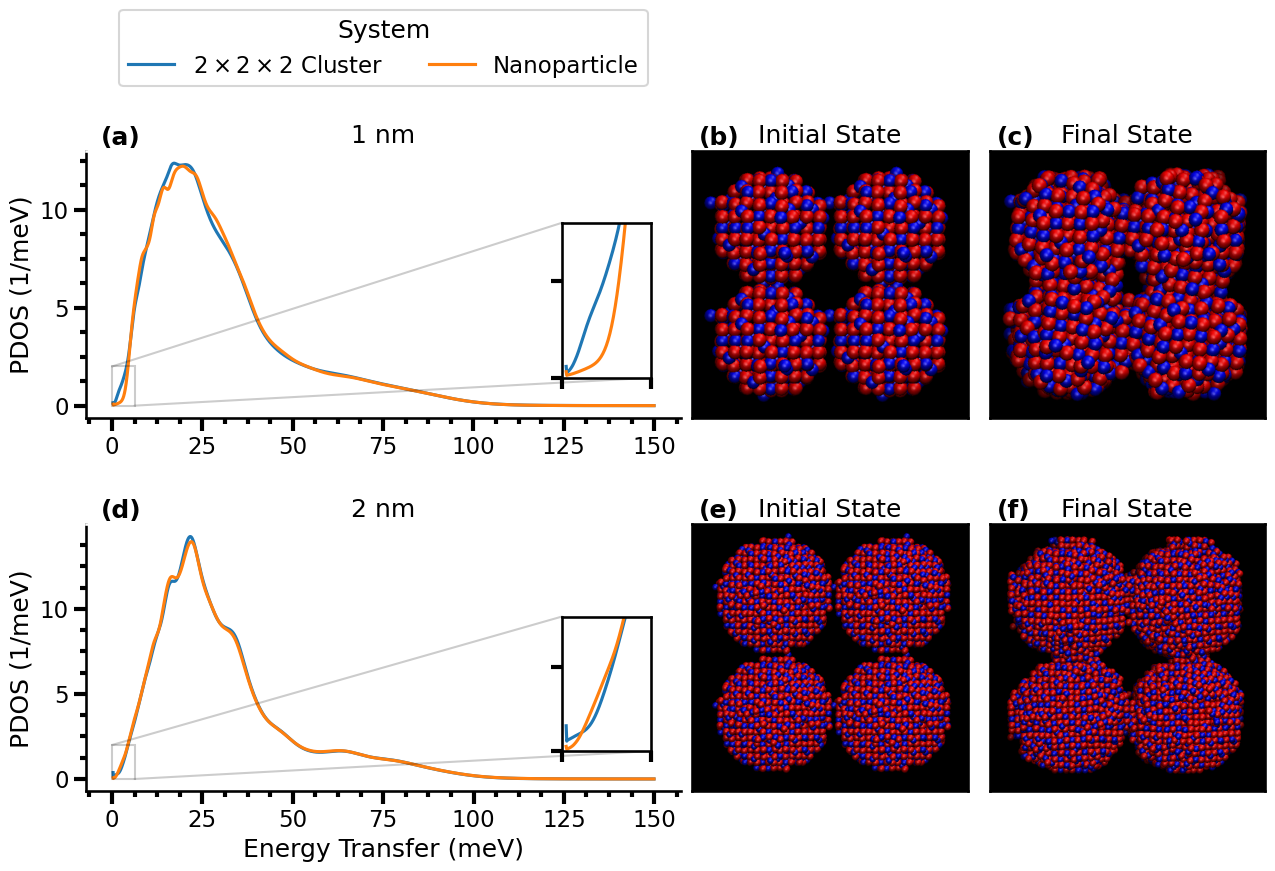

In [ ]:
emin,emax=0,150

weight="Incoherent"
fig, axs = plt.subplots( nrows=2,ncols=3,figsize=(7*2,4*2),width_ratios=(2,1,1)
                       # ,height_ratios =(3,2)
                       )
sns.set_context("talk")



labx=0.025
laby=1.025

ax=axs[0,0]
ax.text(labx, laby, '(a)',weight='bold' ,transform=ax.transAxes)

df_tmp=df_dos_gromacs.query(" %f < `Energy Transfer (meV)` and `Energy Transfer (meV)` < %f and Weight== '%s' and `Radius (nm)` == %d "%(emin,emax,weight,1))
sns.lineplot(data=df_tmp
                    ,y="Normalized Count"
                    ,x='Energy Transfer (meV)'
                    ,hue="System"

                     ,ax=ax
               )

ax.spines['bottom'].set_color('0')
ax.spines['top'].set_color('1')
ax.spines['right'].set_color('1')
ax.spines['left'].set_color('0')
ax.tick_params(direction='out', width=3, bottom=True, left=True)
ax.grid(False)
ax.set_xlabel("")
ax.set_ylabel("PDOS (1/meV)")
ax.set_title("1 nm")

ax.xaxis.set_minor_locator(MultipleLocator(25/4))
ax.yaxis.set_minor_locator(MultipleLocator(5/4))
ax.tick_params(which='minor', length=4,width=3)

x1, x2, y1, y2 = 0, 25/4, 0, 2
emax,cmax=df_tmp["Energy Transfer (meV)"].max(),df_tmp["Normalized Count"].max()
ratio=emax*y2/(x2*cmax)

xw=0.15
axins = ax.inset_axes(
    [0.8, 0.15, xw, xw*ratio],
    xlim=(x1, x2), ylim=(y1, y2),xticklabels=[], yticklabels=[])
#axins.imshow(Z2, extent=extent, origin="lower")

sns.lineplot(data=df_tmp
                    ,y="Normalized Count"
                    ,x='Energy Transfer (meV)'
                    ,hue="System"
                    ,legend=False
                     ,ax=axins
               )
axins.tick_params(direction='out', width=3, length=8, bottom=True, left=True)
axins.tick_params(which='minor',direction='out', length=8,width=3)
axins.xaxis.set_ticks([0, 25/4], ["", ""])
axins.yaxis.set_ticks([0, 5/4], ["", ""])
axins.grid(False)
axins.set_xlabel("")
axins.set_ylabel("")


ax.indicate_inset_zoom(axins, edgecolor="black",alpha=0.2)


sns.move_legend(ax,'lower center',bbox_to_anchor=(0.5,1.2),ncol=2
           # ,bbox_transform=fig.transFigure
           )


ax=axs[1,0]
ax.text(labx, laby, '(d)',weight='bold' ,transform=ax.transAxes)
df_tmp=df_dos_gromacs.query(" %f < `Energy Transfer (meV)` and `Energy Transfer (meV)` < %f and Weight== '%s' and `Radius (nm)` == %d "%(emin,emax,weight,2))
sns.lineplot(data=df_tmp
                    ,y="Normalized Count"
                    ,x='Energy Transfer (meV)'
                    ,hue="System"
                    ,legend=False
                     ,ax=ax
               )

ax.spines['bottom'].set_color('0')
ax.spines['top'].set_color('1')
ax.spines['right'].set_color('1')
ax.spines['left'].set_color('0')
ax.tick_params(direction='out', width=3, bottom=True, left=True)
ax.grid(False)
ax.set_ylabel("PDOS (1/meV)")
ax.set_title("2 nm")

ax.xaxis.set_minor_locator(MultipleLocator(25/4))
ax.yaxis.set_minor_locator(MultipleLocator(5/4))
ax.tick_params(which='minor', length=4,width=3)

x1, x2, y1, y2 = 0, 25/4, 0, 2
emax,cmax=df_tmp["Energy Transfer (meV)"].max(),df_tmp["Normalized Count"].max()
ratio=emax*y2/(x2*cmax)

xw=0.15
axins = ax.inset_axes(
    [0.8, 0.15, xw, xw*ratio],
    xlim=(x1, x2), ylim=(y1, y2),xticklabels=[], yticklabels=[])
#axins.imshow(Z2, extent=extent, origin="lower")

sns.lineplot(data=df_tmp
                    ,y="Normalized Count"
                    ,x='Energy Transfer (meV)'
                    ,hue="System"
                    ,legend=False
                     ,ax=axins
               )
axins.tick_params(direction='out', width=3, length=8, bottom=True, left=True)
axins.tick_params(which='minor',direction='out', length=8,width=3)
axins.xaxis.set_ticks([0, 25/4], ["", ""])
axins.yaxis.set_ticks([0, 5/4], ["", ""])
axins.grid(False)
axins.set_xlabel("")
axins.set_ylabel("")


ax.indicate_inset_zoom(axins, edgecolor="black",alpha=0.2)


label_index=list("bcef")
for j,size in enumerate([1,2]):
    for i,state in enumerate(["initial","final"]):
        ax=axs[j,i+1]
        ax.text(labx, laby, '(%s)'%label_index[i+2*j],weight='bold' ,transform=ax.transAxes)
        ax.set_title("%s State"%state.capitalize())
        img = np.asarray(Image.open('../figures/structures/%dnm_cluster_200K_%s.png'%(size,state)))
        ax.imshow(img)
        ax.set_yticks([])
        ax.set_xticks([])


# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.95, 
                    top=0.9, 
                    wspace=0.0, 
                    hspace=0.4
                   )

plt.savefig("../figures/fig8.pdf", pad_inches=0.2,bbox_inches="tight")
